In [1]:
import torch
import numpy as np
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from datasets import load_dataset
import time
from typing import Dict, List
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt

In [5]:
import torch
from torch.nn import CrossEntropyLoss
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from datasets import load_dataset
import time
import matplotlib.pyplot as plt
from typing import Dict, List

class GPT2Quantizer:
    def __init__(self, model_name: str = "gpt2"):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = GPT2LMHeadModel.from_pretrained(model_name).to(self.device)
        self.tokenizer = GPT2Tokenizer.from_pretrained(model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token
        self.model.config.pad_token_id = self.tokenizer.pad_token_id
        self.quantized_params = set()
        print(f"Model loaded on {self.device}")

    def load_dataset(self, num_samples=3000):
        dataset = load_dataset("/kaggle/input/wiki-20220301-en")        
        dataset = dataset["train"].select(range(num_samples))
        texts = [text['text'] for text in dataset]
        print(f"Total samples selected: {len(texts)}")
        if len(texts) < num_samples:
            raise ValueError(f"Only {len(texts)} samples available. Consider using a smaller 'num_samples' value.")
        
        print(f"Using {len(texts)} samples for evaluation")
        return texts

    def measure_memory(self, model) -> Dict[str, float]:
        fp32_memory = 0
        int8_memory = 0
        
        for name, param in model.named_parameters():
            num_elements = param.nelement()
            
            if name in self.quantized_params:
                int8_memory += num_elements
            else:
                fp32_memory += num_elements * 4
                
        fp32_memory = fp32_memory / (1024 * 1024)
        int8_memory = int8_memory / (1024 * 1024)
        total_memory = fp32_memory + int8_memory
        
        return {'total_mb': total_memory}

    def measure_latency(self, model, input_texts: list, num_runs=1) -> float:
        latencies = []
        model = model.to(self.device)
        
        with torch.no_grad():
            for input_text in input_texts[0:10]:
                inputs = self.tokenizer(input_text[:512], return_tensors="pt", padding=True, truncation=True)
                inputs = {k: v.to(self.device) for k, v in inputs.items()}
                
                for _ in range(num_runs):
                    start_time = time.time()
                    model(**inputs)
                    latencies.append(time.time() - start_time)
        
        avg_latency = sum(latencies) / len(latencies)
        torch.cuda.synchronize() if torch.cuda.is_available() else None  # Ensure CUDA operations are complete
        return avg_latency

    def calculate_perplexity(self, model, texts: List[str], max_length=512) -> float:
        total_loss = 0
        total_length = 0
        
        model.eval()
        with torch.no_grad():
            for text in texts:
                inputs = self.tokenizer(text[:max_length], return_tensors="pt").to(self.device)
                labels = inputs.input_ids
                
                outputs = model(**inputs)
                logits = outputs.logits
                
                shift_logits = logits[..., :-1, :].contiguous()
                shift_labels = labels[..., 1:].contiguous()
                
                loss_fct = CrossEntropyLoss(reduction='sum')
                loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
                
                total_loss += loss.item()
                total_length += labels.size(1) - 1
        
        return torch.exp(torch.tensor(total_loss / total_length)).item()

    def quantize_tensor(self, tensor: torch.Tensor, num_bits=8) -> torch.Tensor:
        max_val = torch.max(torch.abs(tensor))
        
        # Avoid division by zero
        if max_val == 0:
            return torch.zeros_like(tensor).to(torch.int8)
        scale = (2 ** (num_bits - 1) - 1) / max_val        
        quantized = torch.round(tensor * scale)
        quantized = torch.clamp(quantized, -2**(num_bits-1), 2**(num_bits-1)-1)
        return quantized

    def quantize_model_full(self, model, num_bits=8):
        quantized_model = type(model)(model.config)
        quantized_model.load_state_dict(model.state_dict())
        
        # Clear previous quantization tracking
        self.quantized_params = set()
        
        for name, param in quantized_model.named_parameters():
            if 'weight' in name:  # Quantize weights
                param.data = self.quantize_tensor(param.data, num_bits)
                self.quantized_params.add(name)
        
        return quantized_model

    def quantize_model_selective(self, model, target_layers: List[str], num_bits=8):
        quantized_model = type(model)(model.config)
        quantized_model.load_state_dict(model.state_dict())        
        self.quantized_params = set()
        
        for name, param in quantized_model.named_parameters():
            if any(layer in name for layer in target_layers) and 'weight' in name:
                param.data = self.quantize_tensor(param.data, num_bits)
                self.quantized_params.add(name)  # Track quantized parameters
        
        return quantized_model

    def evaluate_model(self, model, texts: List[str], num_latency_runs=1) -> Dict:
        memory_metrics = self.measure_memory(model)
        
        return {
            'total_memory_mb': memory_metrics['total_mb'],
            'latency_sec': self.measure_latency(model, texts, num_latency_runs),
            'perplexity': self.calculate_perplexity(model, texts)
        }

    def plot_results(self, results: Dict[str, Dict[str, float]], title: str):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
        fig.suptitle(title, fontsize=18)
        
        models = list(results.keys())        
        colors = ['red', 'blue', 'green']        
        total_memory = [results[model]['total_memory_mb'] for model in models]
        
        ax1.bar(models, total_memory, color=colors[:len(models)])
        ax1.set_title('Memory Usage (Total)', fontsize=14)
        ax1.set_ylabel('Memory (MB)', fontsize=12)
        
        latencies = [results[model]['latency_sec'] for model in models]
        ax2.bar(models, latencies, color=colors[:len(models)])
        ax2.set_title('Inference Latency', fontsize=14)
        ax2.set_ylabel('Latency (seconds)', fontsize=12)
        
        perplexities = [results[model]['perplexity'] for model in models]
        ax3.bar(models, perplexities, color=colors[:len(models)])
        ax3.set_title('Perplexity', fontsize=14)
        ax3.set_ylabel('Perplexity Score', fontsize=12)

        plt.tight_layout()
        fig.subplots_adjust(top=0.85)
        ax1.grid(True, axis='y', linestyle='--', alpha=0.7)
        ax2.grid(True, axis='y', linestyle='--', alpha=0.7)
        ax3.grid(True, axis='y', linestyle='--', alpha=0.7)        
        plt.show()

    def print_detailed_results(self, results: Dict[str, Dict[str, float]]):
         for model_name, metrics in results.items():
             print(f"\n{model_name}:")
             print(f"  Memory :{metrics['total_memory_mb']:.2f} MB")
             print(f"  Latency: {metrics['latency_sec']:.4f} sec")
             print(f"  Perplexity: {metrics['perplexity']:.2f}")

In [12]:
quantizer = GPT2Quantizer()
texts = quantizer.load_dataset(num_samples=3000)

# Baseline evaluation
print("Baseline Evaluation")
baseline_metrics = quantizer.evaluate_model(quantizer.model, texts)
print(baseline_metrics)

# Full model quantization (8-bit)
print("Performing Whole Model Quantization")
quantized_model_full = quantizer.quantize_model_full(quantizer.model, num_bits=8)
quantized_full_metrics = quantizer.evaluate_model(quantized_model_full, texts)
print(quantized_full_metrics)

# Selective quantization
print("Performing Selective Quantization")
attn_layers = ['attn.c_attn', 'attn.c_proj']
quantized_model_selective = quantizer.quantize_model_selective(quantizer.model, attn_layers, num_bits=8)
quantized_selective_metrics = quantizer.evaluate_model(quantized_model_selective, texts)
print(quantized_selective_metrics)


Loading widget...
Loading widget...
Total samples selected: 3000
Using 3000 samples for evaluation

Baseline Evaluation
{'total_memory_mb': 474.7001953125, 'latency_sec': 0.08619623536567383, 'perplexity': 31.616287231445312}

Performing Whole Model Quantization
{'total_memory_mb': 118.96728515625, 'latency_sec': 0.05486387634277344, 'perplexity': inf}

Performing Selective Quantization
{'total_memory_mb': 393.7001953125, 'latency_sec': 0.06727205181121826, 'perplexity': 69637184.0}


In [10]:
results = {
    'Baseline': baseline_metrics,
    'Full-8bit': quantized_full_metrics,
    'Selective-8bit': quantized_selective_metrics
}

In [15]:
quantizer.print_detailed_results(results)

Baseline:
  Memory: 474.70 MB
  Latency: 0.0862 sec
  Perplexity: 31.62

Full-8bit:
  Memory: 118.97 MB
  Latency: 0.0549 sec
  Perplexity: inf

Selective-8bit:
  Memory: 393.70 MB
  Latency: 0.0673 sec
  Perplexity: 69637184.00


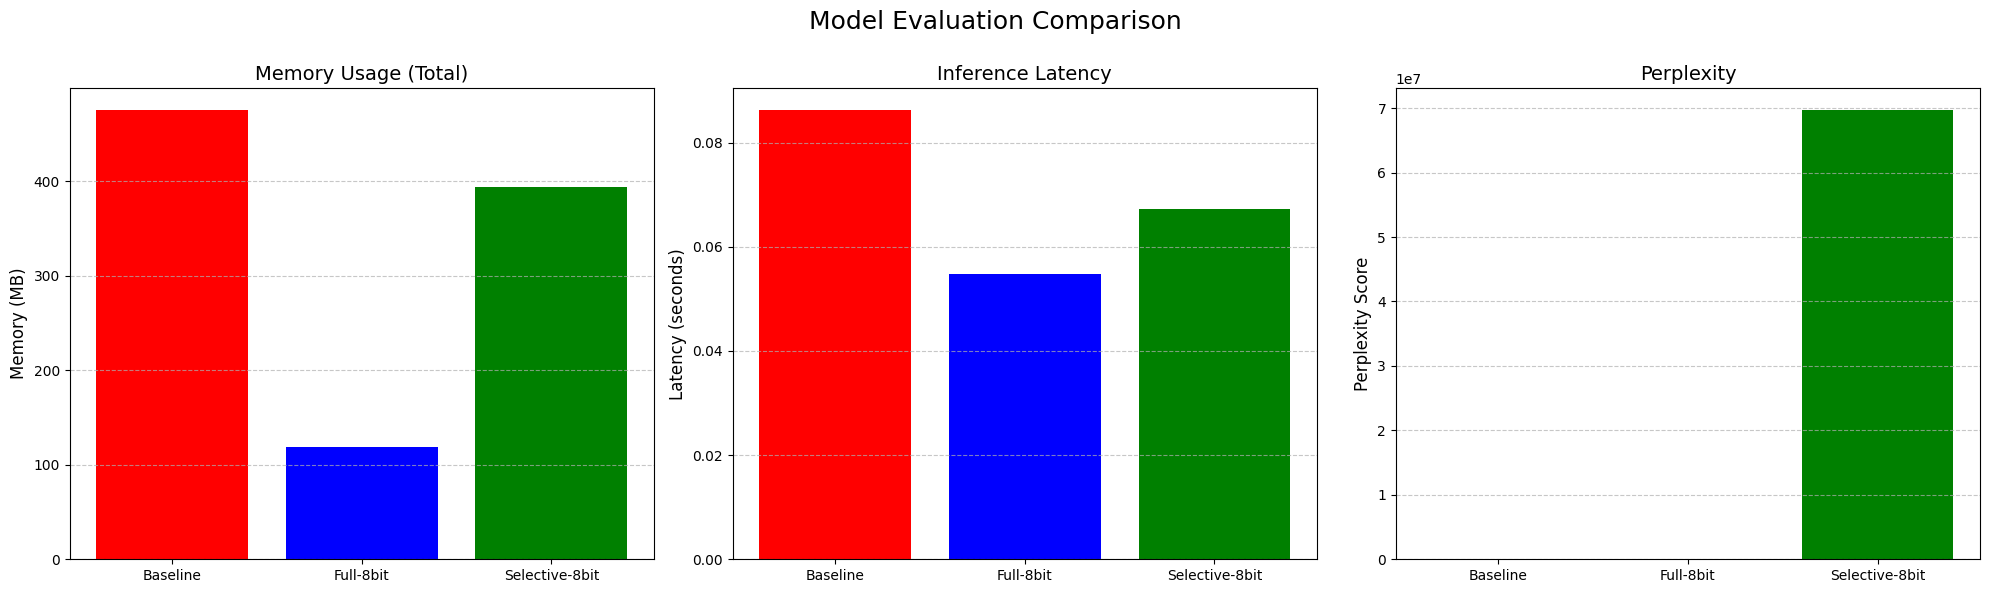

In [19]:

quantizer.plot_results(results, "GPT2 Quantization Performance Comparison")
